In [1]:
import sys
import requests
import numpy as np

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM

In [2]:
r = requests.get("https://cs.stanford.edu/people/karpathy/char-rnn/warpeace_input.txt")
raw_txt = r.text

In [3]:
len(raw_txt)

3258246

In [4]:
chars = sorted(list(set(raw_txt)))
print("Corpus: {}".format(len(raw_txt)))
print("Categories: {}".format(len(chars)))

Corpus: 3258246
Categories: 87


In [5]:
ix_to_char = {ix:char for ix, char in enumerate(chars)}
char_to_ix = {char:ix for ix, char in enumerate(chars)}

In [6]:
maxlen = 10
x_data = []
y_data = []
for i in range(0, len(raw_txt) - maxlen, 1):
  in_seq = raw_txt[i: i + maxlen]
  out_seq = raw_txt[i + maxlen]

  x_data.append([char_to_ix[char] for char in in_seq])
  y_data.append([char_to_ix[out_seq]])

nb_chars = len(x_data)
print('Number of sequences:', int(len(x_data)/maxlen))

Number of sequences: 325823


In [7]:
# scale and transform data
x = np.reshape(x_data , (nb_chars , maxlen , 1))
n_vocab = len(chars)
x = x/float(n_vocab)
x.shape

(3258236, 10, 1)

In [8]:
y = tf.keras.utils.to_categorical(y_data)
y.shape

(3258236, 86)

**Defining Model**

In [9]:
Model = tf.keras.Sequential(
    [
     tf.keras.layers.LSTM(800 ,input_shape = (len(x[1]) , 1) ,return_sequences = True),
     tf.keras.layers.Dropout(0.2),
     tf.keras.layers.LSTM(800,return_sequences = True),
     tf.keras.layers.Dropout(0.2),
     tf.keras.layers.LSTM(800),
     tf.keras.layers.Dropout(0.2),
     tf.keras.layers.Dense(len(y[1]),activation = 'softmax')
     ]
)

In [10]:
Model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

In [11]:
Model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 800)           2566400   
_________________________________________________________________
dropout (Dropout)            (None, 10, 800)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 800)           5123200   
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 800)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 800)               5123200   
_________________________________________________________________
dropout_2 (Dropout)          (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 86)                6

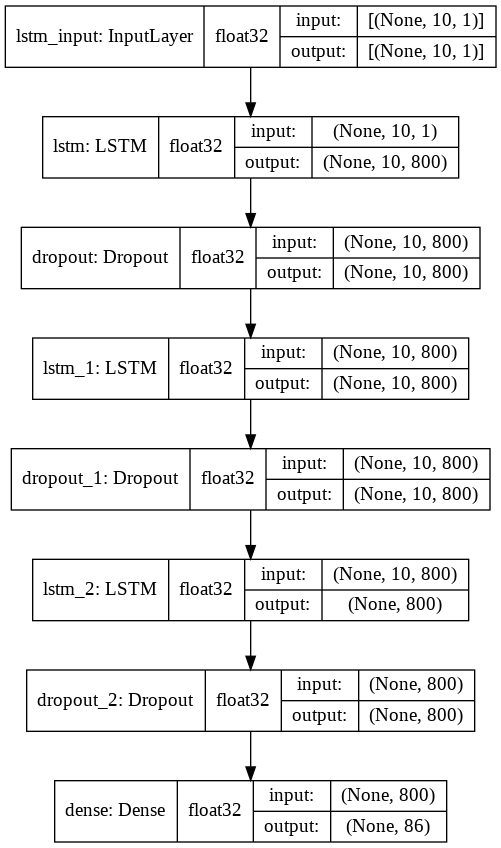

In [12]:
tf.keras.utils.plot_model(Model, 'multilayer_model.png', show_shapes=True, show_dtype=True, show_layer_names=True)

**Creating Checkpoints**

In [13]:
filepath = "/content/drive/MyDrive/Dataset/TensorFlow_Advanced_Text_Generation/model_weights_saved.hdf5"

In [14]:
checkpoint = ModelCheckpoint(filepath, monitor = 'loss', verbose = 1, save_best_only = True, mode = 'min')

In [15]:
model_callbacks = [checkpoint]

**CustomCallback Class**

In [16]:
epoch_number = 0
filename = '/content/drive/MyDrive/Dataset/TensorFlow_Advanced_Text_Generation/predictions.txt'
file = open(filename , 'w')
file.truncate()
file.close()

In [17]:
class CustomCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self , epoch , logs = None):
    global epoch_number
    epoch_number = epoch_number + 1
    filename = '/content/drive/MyDrive/Dataset/TensorFlow_Advanced_Text_Generation/predictions.txt'
    file = open(filename , 'a')
    seed = "looking fo"
    pattern = []
    for i in seed:
      value = char_to_ix[i]
      pattern.append(value)
    file.seek(0)
    file.write("\n\n Epoch number :{}\n\n".format(epoch_number))
    for i in range(100):
      X = np.reshape(pattern ,(1, len(pattern) , 1))
      X = X/float(n_vocab)
      int_prediction = Model.predict(X, verbose = 0)
      index = np.argmax(int_prediction)
      prediction = ix_to_char[index]
      file.write(prediction)
      pattern.append(index)
      pattern = pattern[1:len(pattern)]
      file.close()

In [ ]:
Model.fit(x, y , batch_size = 200, epochs = 20, callbacks = [CustomCallback(), model_callbacks])

Epoch 1/20
  537/16292 [..............................] - ETA: 9:25 - loss: 3.0535

**Training Continuation**

In [ ]:
try:
  Model.load_weights(filepath)
except Exception as error:
  print("Error loading in model : {}".format(error))

In [ ]:
Model.fit(x, y, batch_size = 200, epochs = 10, callbacks = [CustomCallback(), model_callbacks])